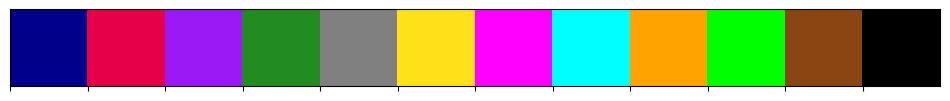

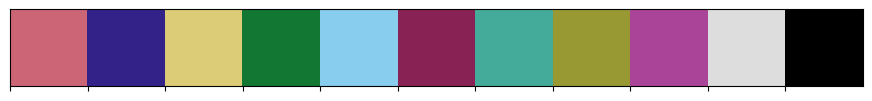

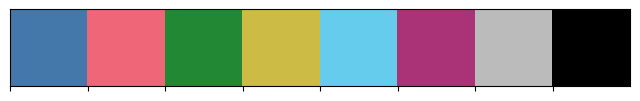

In [1]:
from glob import glob
import itertools
import warnings

warnings.filterwarnings("ignore")


import math
from typing import Tuple
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl

from polyphys.visualize.plotter import PROJECT_DETAILS as PD
from polyphys.visualize.plotter import TITLE_STYLES as TS
from polyphys.visualize.plotter import ATTRIBUTE_LABELS as AL
from polyphys.visualize.plotter import AMIRHSI_COLORS as AC
from polyphys.visualize.plotter import PAUL_TOL_MUTED as PTM
from polyphys.visualize.plotter import PAUL_TOL_BRIGHT as PTB

from polyphys.visualize import tuner
from polyphys.manage import organizer
from polyphys.probe import logger
from polyphys.manage import utilizer 
from polyphys.manage.parser import TwoMonDep
from polyphys.analyze import clusters
from polyphys.analyze import measurer
import warnings
warnings.filterwarnings("ignore")
#database = '../../Datasets/'
database = '/Users/amirhsi_mini/research_data/analysis/'
#save_to_data = '/Users/amirhsi/Library/CloudStorage/OneDrive-UniversityofWaterloo/PhD_Research/Jupyter/datasets/'
save_to_data = '/Users/amirhsi/Library/CloudStorage/OneDrive-UniversityofWaterloo/PhD_Research/Jupyter/datasets/TwoMonDep-allInOne/'
save_to_fig = '/Users/amirhsi/Library/CloudStorage/OneDrive-UniversityofWaterloo/PhD_Research/Jupyter/test_plots/TwoMonDep/'
sns.palplot(AC)
sns.palplot(PTM)
sns.palplot(PTB)

## Extract dataset for the first time

In [2]:
project = 'TwoMonDep'

log_details = {
    'TwoMonDep': {
        'space_pat': 'nm*am*ac*nc*',
        'hierarchy': '/am*.log',  # dir/file
        'parser': TwoMonDep,
        'lineage': 'whole',
        'geometry': 'cubic',
        'group': 'bug',
        'topology': 'atom',
        'product_idx': 1
    }
}

log_db = '/Users/amirhsi/research_data/'+project+'-logs/'
space_dbs = glob(log_db + log_details[project]['space_pat'] + '-logs')
space_dbs.sort()
print(space_dbs)

['/Users/amirhsi/research_data/TwoMonDep-logs/nm2am10.0ac1.0nc71620-logs', '/Users/amirhsi/research_data/TwoMonDep-logs/nm2am10.0ac1.0nc95493-logs', '/Users/amirhsi/research_data/TwoMonDep-logs/nm2am5.0ac1.0nc0-logs', '/Users/amirhsi/research_data/TwoMonDep-logs/nm2am5.0ac1.0nc11937-logs', '/Users/amirhsi/research_data/TwoMonDep-logs/nm2am5.0ac1.0nc8953-logs']


In [3]:
thermos = []
#run_stats = []
#wall_times = []
for space_db in space_dbs:
    #print(space_db)
    space = space_db.split("/")[-1]
    logs = glob(space_db + log_details[project]['hierarchy'])
    logs = organizer.sort_filenames(logs,  fmts=['.log']) # sorted
    logs = [log[0] for log in logs]
    for log in logs:
        log_info = log_details[project]['parser'](
            log,
            log_details[project]['lineage'],
            log_details[project]['geometry'],
            log_details[project]['group'],
            log_details[project]['topology']
        )
        lineage = log_details[project]['lineage']
        # handling product_idx in segmented logs:
        if lineage == 'segment' and log_info.segment_id>1:
            product_idx = 0
        # handling product_idx in restart logs which do not have product phase
        if  not (log.endswith('restart.log') | log.endswith('restart2ndRound.log')):
            product_idx = log_details[project]['product_idx']
        else:
            product_idx = 0
        try:
            log_data = logger.LammpsLog(log, product_idx)
        except (logger.BrokenLogError, IndexError):
            print("broken log: ", log_info.filepath.split("/")[-1])
        log_data.extract_thermo()
        #log_data.extract_run_stat()
        thermo = log_data.thermo
        #run_stat = log_data.run_stat
        #wall_time = log_data.wall_time
        for attr_name in log_info._lineage_attributes[lineage].keys():
            attr_value = getattr(log_info, attr_name)
            thermo[attr_name] = attr_value
        attr_names = ['phi_m_bulk', 'rho_m_bulk', 'phi_c_bulk', 'rho_c_bulk']
        for attr_name in attr_names:
            attr_value = getattr(log_info, attr_name)
            thermo[attr_name] = attr_value
        thermo['phi_c_bulk_round'] = thermo['phi_c_bulk'].apply(lambda x: round(x/0.025) * 0.025)
        for lineage_name in log_info.genealogy:
            attr_value = getattr(log_info, lineage_name)
            thermo[lineage_name] = attr_value
            #run_stat[lineage_name] = attr_value
            #wall_time[lineage_name] = attr_value
        thermos.append(thermo)
        #run_stats.append(run_stat)
        #wall_times.append(wall_time)

output = "-".join(["allInOne", project, "thermos"])
thermos = pd.concat(thermos)
thermos.drop_duplicates(inplace=True)
thermos.reset_index(inplace=True, drop=True)
thermos.to_parquet(
    save_to_data + output + ".parquet.brotli", index=False, compression='brotli'
)
output = "-".join(["allInOne", project, "runStat"])
#run_stats = pd.concat(run_stats)
#run_stats.reset_index(inplace=True, drop=True)
#run_stats.to_csv(save_to_data + output + ".csv", index=False)
#output = "-".join(["allInOne", project, "wallTimeStat"])
#wall_times = pd.concat(wall_times)
#wall_times.reset_index(inplace=True, drop=True)
#wall_times.to_csv(save_to_data + output + ".csv", index=False)

## Working with dataset

## LJ potential and force

In [4]:
def pot_LJ(r: float, sig: float = 1, eps: float = 1) -> float:
    """
    Calculate the Lennard-Jones potential for a given distance.

    The Lennard-Jones potential is a mathematical model that approximates the interaction 
    between a pair of neutral atoms or molecules. It is widely used in physics and chemistry 
    to describe the potential energy of interactions between particles.

    Parameters
    ----------
    r : float
        The distance between two interacting particles. It must be greater than zero 
        to avoid division by zero.
    
    sig : float, optional (default=1)
        The distance at which the potential between two particles is zero. It is also 
        known as the "collision diameter" or "finite size" parameter.
    
    eps : float, optional (default=1)
        The depth of the potential well, representing the strength of the attraction 
        between the particles.

    Returns
    -------
    float
        The Lennard-Jones potential energy at distance `r`.

    Notes
    -----
    The potential is calculated using the formula:
    
        U(r) = 4 * eps * [(sig/r)^12 - (sig/r)^6]
    
    In this function, the powers of `(sig/r)` are optimized by using repeated 
    multiplication rather than exponentiation to improve performance.
    
    The intermediate values calculated are:
    - `sr_ratio`: The ratio between `sig` and `r`.
    - `sr_ratio2`: The square of `sr_ratio`, i.e., `(sig/r)^2`.
    - `sr_ratio6`: The sixth power of `sr_ratio`, i.e., `(sig/r)^6`.
    
    The final potential is computed as:
    
        pot = 4 * eps * (sr_ratio6^2 - sr_ratio6)
    
    This approach avoids the use of exponentiation (`**`) in favor of 
    multiplication for better performance.
    
    Examples
    --------
    >>> pot_LJ(2.0)
    -0.0615234375
    
    >>> pot_LJ(2.0, sig=0.8, eps=0.5)
    -0.0146484375

    """
    sr_ratio = sig / r
    sr_ratio2 = sr_ratio * sr_ratio
    sr_ratio6 = sr_ratio2 * sr_ratio2 * sr_ratio2  # Equivalent to (sig/r)^6
    pot = 4 * eps * (sr_ratio6 * sr_ratio6 - sr_ratio6)
    return pot


def pot_LJT(r: float, r_cut: float, sig: float, eps: float) -> float:
    """
    Calculate the truncated Lennard-Jones potential for a given distance.

    The truncated Lennard-Jones potential is commonly used to model interactions between 
    particles where the potential is considered only up to a specified cutoff distance. 
    Beyond this distance, the potential is set to zero to save computation and model 
    finite interaction ranges.

    Parameters
    ----------
    r : float
        The distance between two interacting particles. It must be greater than zero 
        to avoid division by zero.
    
    r_cut : float
        The cutoff distance beyond which the potential is set to zero. It defines the 
        range of interaction between the particles.
    
    sig : float
        The distance at which the potential between two particles is zero. It is also 
        known as the "collision diameter" or "finite size" parameter.
    
    eps : float
        The depth of the potential well, representing the strength of the attraction 
        between the particles.

    Returns
    -------
    float
        The truncated Lennard-Jones potential energy at distance `r`. If `r > r_cut`, 
        the potential is zero.

    Notes
    -----
    This function uses the Lennard-Jones potential formula only for distances less 
    than or equal to `r_cut`:

        U(r) = 4 * eps * [(sig/r)^12 - (sig/r)^6] for r <= r_cut

    Otherwise, the potential is set to zero.
    
    The `pot_LJ` function is optimized for better performance by avoiding the use of 
    exponentiation (`**`) and replacing it with multiplications.

    Examples
    --------
    >>> pot_LJ_cut(2.0, 3.0, sig=1.0, eps=1.0)
    -0.0615234375
    
    >>> pot_LJ_cut(3.5, 3.0, sig=1.0, eps=1.0)
    0

    """
    # Only calculate potential if r is within the cutoff distance
    if r <= r_cut:
        sr_ratio = sig / r
        sr_ratio2 = sr_ratio * sr_ratio
        sr_ratio6 = sr_ratio2 * sr_ratio2 * sr_ratio2  # (sig/r)^6
        return 4 * eps * (sr_ratio6 * sr_ratio6 - sr_ratio6)  # Lennard-Jones potential
    else:
        return 0


def pot_LJTS(r: float, r_cut: float, sig: float, eps: float) -> float:
    """
    Calculate the truncated and shifted Lennard-Jones potential for a given distance.

    The truncated and shifted Lennard-Jones potential is used to model interactions 
    between particles with a finite range while ensuring that the potential smoothly 
    goes to zero at the cutoff distance. This approach enhances the stability of 
    molecular dynamics simulations by avoiding discontinuities in the potential energy.

    Parameters
    ----------
    r : float
        The distance between two interacting particles. It must be greater than zero 
        to avoid division by zero.
    
    r_cut : float
        The cutoff distance beyond which the potential is set to zero. It defines the 
        interaction range between particles, and the potential is shifted to be zero at 
        `r_cut`.
    
    sig : float
        The distance at which the potential between two particles is zero. It is also 
        known as the "collision diameter" or "finite size" parameter.
    
    eps : float
        The depth of the potential well, representing the strength of the attraction 
        between the particles.

    Returns
    -------
    float
        The truncated and shifted Lennard-Jones potential energy at distance `r`. 
        If `r > r_cut`, the potential is zero.

    Notes
    -----
    The potential is calculated as follows:
    
        U(r) = 4 * eps * [(sig/r)^12 - (sig/r)^6] - U(r_cut) for r <= r_cut
        U(r) = 0 for r > r_cut
    
    where `U(r_cut)` is the value of the Lennard-Jones potential at the cutoff 
    distance. This ensures the potential is zero at `r_cut`.

    Examples
    --------
    >>> pot_LJ_truncated_shifted(2.0, 3.0, sig=1.0, eps=1.0)
    -0.0613555908203125
    
    >>> pot_LJ_truncated_shifted(3.5, 3.0, sig=1.0, eps=1.0)
    0

    """
    # Only calculate potential if r is within the cutoff distance
    if r <= r_cut:
        sr_ratio = sig / r
        sr_ratio2 = sr_ratio * sr_ratio
        sr_ratio6 = sr_ratio2 * sr_ratio2 * sr_ratio2  # (sig/r)^6
        lj_potential = 4 * eps * (sr_ratio6 * sr_ratio6 - sr_ratio6)  # LJ potential at r
        
        # Calculate potential at r_cut for shifting
        sr_cut_ratio = sig / r_cut
        sr_cut_ratio2 = sr_cut_ratio * sr_cut_ratio
        sr_cut_ratio6 = sr_cut_ratio2 * sr_cut_ratio2 * sr_cut_ratio2  # (sig/r_cut)^6
        lj_potential_cut = 4 * eps * (sr_cut_ratio6 * sr_cut_ratio6 - sr_cut_ratio6)  # LJ potential at r_cut
        
        return lj_potential - lj_potential_cut
    else:
        return 0


def force_LJ(dx: float, dy: float, dz: float, sig: float = 1, eps: float = 1) -> Tuple[float, float, float]:
    """
    Calculate the Lennard-Jones force and its components for two particles, given the
    differences in their positions in the x, y, and z directions.
    
    Parameters
    ----------
    dx : float
        The difference in the x-coordinates of the two particles (x2 - x1).
    
    dy : float
        The difference in the y-coordinates of the two particles (y2 - y1).
    
    dz : float
        The difference in the z-coordinates of the two particles (z2 - z1).
    
    sig : float, optional (default=1)
        The distance at which the potential between two particles is zero.
    
    eps : float, optional (default=1)
        The depth of the potential well, representing the strength of the attraction 
        between the particles.
    
    Returns
    -------
    Tuple[float, float, float]
        The components of the Lennard-Jones force in the x, y, and z directions, 
        as (F_x, F_y, F_z).
    
    Notes
    -----
    The force is calculated using the formula:
    
        F(r) = 24 * eps * [(2 * (sig / r)^12 - (sig / r)^6)] / r
        
    and the components of the force are:
    
        F_x = F(r) * dx / r
        F_y = F(r) * dy / r
        F_z = F(r) * dz / r
    
    Examples
    --------
    >>> force_LJ(1, 1, 1)
    (0.17578125, 0.17578125, 0.17578125)
    
    >>> force_LJ(2, 2, 2, sig=0.8, eps=0.5)
    (0.0048828125, 0.0048828125, 0.0048828125)
    """
    # Calculate the magnitude of the distance between the particles
    r = math.sqrt(dx*dx + dy*dy + dz*dz)
    
    if r == 0:
        raise ValueError("The distance between the particles cannot be zero.")
    
    # Compute the Lennard-Jones force magnitude
    sr_ratio = sig / r
    sr_ratio2 = sr_ratio * sr_ratio
    sr_ratio6 = sr_ratio2 * sr_ratio2 * sr_ratio2  # (sig/r)^6
    
    # Force magnitude
    F_r = 24 * eps * (2 * sr_ratio6 * sr_ratio6 - sr_ratio6) / r
    
    # Components of the force
    F_x = F_r * dx / r
    F_y = F_r * dy / r
    F_z = F_r * dz / r
    
    return F_x, F_y, F_z


def force_LJT(dx: float, dy: float, dz: float, r_cut: float, sig: float = 1, eps: float = 1) -> Tuple[float, float, float]:
    """
    Calculate the truncated Lennard-Jones force and its components for two particles.
    
    The truncated Lennard-Jones force is calculated only if the distance between the
    particles is less than or equal to the cutoff distance. Beyond the cutoff distance, 
    the force is set to zero.
    
    Parameters
    ----------
    dx : float
        The difference in the x-coordinates of the two particles (x2 - x1).
    
    dy : float
        The difference in the y-coordinates of the two particles (y2 - y1).
    
    dz : float
        The difference in the z-coordinates of the two particles (z2 - z1).
    
    r_cut : float
        The cutoff distance beyond which the force is considered zero.
    
    sig : float, optional (default=1)
        The distance at which the potential between two particles is zero.
    
    eps : float, optional (default=1)
        The depth of the potential well, representing the strength of the attraction 
        between the particles.
    
    Returns
    -------
    Tuple[float, float, float]
        The components of the truncated Lennard-Jones force in the x, y, and z directions, 
        as (F_x, F_y, F_z). Returns (0, 0, 0) if the distance exceeds the cutoff.
    
    Notes
    -----
    The force is calculated only for distances less than or equal to the cutoff:
    
        F(r) = 24 * eps * [(2 * (sig / r)^12 - (sig / r)^6)] / r for r <= r_cut
    
    Examples
    --------
    >>> force_LJT(1, 1, 1, r_cut=3.0)
    (0.17578125, 0.17578125, 0.17578125)
    
    >>> force_LJT(3, 3, 3, r_cut=2.5)
    (0.0, 0.0, 0.0)
    """
    # Calculate the magnitude of the distance between the particles
    r = math.sqrt(dx*dx + dy*dy + dz*dz)
    
    if r == 0:
        raise ValueError("The distance between the particles cannot be zero.")
    
    # Only calculate force if the distance is within the cutoff
    if r <= r_cut:
        sr_ratio = sig / r
        sr_ratio2 = sr_ratio * sr_ratio
        sr_ratio6 = sr_ratio2 * sr_ratio2 * sr_ratio2  # (sig/r)^6
        
        # Force magnitude
        F_r = 24 * eps * (2 * sr_ratio6 * sr_ratio6 - sr_ratio6) / r
        
        # Components of the force
        F_x = F_r * dx / r
        F_y = F_r * dy / r
        F_z = F_r * dz / r
        
        return F_x, F_y, F_z
    else:
        # Beyond the cutoff, the force is zero
        return 0.0, 0.0, 0.0
    
def force_LJTS(dx: float, dy: float, dz: float, r_cut: float, sig: float = 1, eps: float = 1) -> Tuple[float, float, float]:
    """
    Calculate the truncated and shifted Lennard-Jones force and its components for two particles.
    
    The truncated and shifted Lennard-Jones force ensures that the force smoothly 
    goes to zero at the cutoff distance. This is achieved by subtracting the value 
    of the Lennard-Jones potential at the cutoff distance from the force.
    
    Parameters
    ----------
    dx : float
        The difference in the x-coordinates of the two particles (x2 - x1).
    
    dy : float
        The difference in the y-coordinates of the two particles (y2 - y1).
    
    dz : float
        The difference in the z-coordinates of the two particles (z2 - z1).
    
    r_cut : float
        The cutoff distance beyond which the force is considered zero.
    
    sig : float, optional (default=1)
        The distance at which the potential between two particles is zero.
    
    eps : float, optional (default=1)
        The depth of the potential well, representing the strength of the attraction 
        between the particles.
    
    Returns
    -------
    Tuple[float, float, float]
        The components of the truncated and shifted Lennard-Jones force in the x, y, 
        and z directions, as (F_x, F_y, F_z). Returns (0, 0, 0) if the distance exceeds 
        the cutoff.
    
    Notes
    -----
    The force is truncated and shifted so that it smoothly goes to zero at r_cut:
    
        F(r) = 24 * eps * [(2 * (sig / r)^12 - (sig / r)^6)] / r - F(r_cut)
    
    Examples
    --------
    >>> force_LJTS(1, 1, 1, r_cut=3.0)
    (0.17560577392578125, 0.17560577392578125, 0.17560577392578125)
    
    >>> force_LJTS(3, 3, 3, r_cut=2.5)
    (0.0, 0.0, 0.0)
    """
    # Calculate the magnitude of the distance between the particles
    r = math.sqrt(dx*dx + dy*dy + dz*dz)
    
    if r == 0:
        raise ValueError("The distance between the particles cannot be zero.")
    
    # Only calculate force if the distance is within the cutoff
    if r <= r_cut:
        sr_ratio = sig / r
        sr_ratio2 = sr_ratio * sr_ratio
        sr_ratio6 = sr_ratio2 * sr_ratio2 * sr_ratio2  # (sig/r)^6
        
        # Force magnitude at r
        F_r = 24 * eps * (2 * sr_ratio6 * sr_ratio6 - sr_ratio6) / r
        
        # Calculate force at r_cut for shifting
        sr_cut_ratio = sig / r_cut
        sr_cut_ratio2 = sr_cut_ratio * sr_cut_ratio
        sr_cut_ratio6 = sr_cut_ratio2 * sr_cut_ratio2 * sr_cut_ratio2  # (sig/r_cut)^6
        F_r_cut = 24 * eps * (2 * sr_cut_ratio6 * sr_cut_ratio6 - sr_cut_ratio6) / r_cut
        
        # Shifted force magnitude
        F_r_shifted = F_r - F_r_cut
        
        # Components of the force
        F_x = F_r_shifted * dx / r
        F_y = F_r_shifted * dy / r
        F_z = F_r_shifted * dz / r
        
        return F_x, F_y, F_z
    else:
        # Beyond the cutoff, the force is zero
        return 0.0, 0.0, 0.0

## Data analysis

In [5]:
project = 'TwoMonDep'
file_name = "-".join(["allInOne", project, "thermos.parquet.brotli"])
thermos = pd.read_parquet(save_to_data + file_name)
step_cutoff = 3000000
thermos = thermos.loc[thermos['Step']>=step_cutoff,:]
thermos['Time'] = thermos['Step'] * thermos['dt'] 
thermos.columns

Index(['Step', 'Temp', 'Press', 'TotEng', 'PotEng', 'KinEng', 'E_pair',
       'E_vdwl', 'Ecouple', 'Econserve', 'e_spr', 'fx_spr', 'fy_spr', 'fz_spr',
       'fmag_spr', 'e_m1_c', 'fx_m1_c', 'fy_m1_c', 'fz_m1_c', 'e_m2_c',
       'fx_m2_c', 'fy_m2_c', 'fz_m2_c', 'e_m1_m2', 'fx_m1_m2', 'fy_m1_m2',
       'fz_m1_m2', 'nmon', 'dmon', 'lcube', 'dcrowd', 'ncrowd', 'd_sur', 'dt',
       'bdump', 'adump', 'tdump', 'ensemble_id', 'phi_m_bulk', 'rho_m_bulk',
       'phi_c_bulk', 'rho_c_bulk', 'phi_c_bulk_round', 'lineage_name', 'whole',
       'ensemble_long', 'ensemble', 'space', 'Time'],
      dtype='object')

In [6]:
thermos.head()

,Step,Temp,Press,TotEng,PotEng,KinEng,E_pair,E_vdwl,Ecouple,Econserve,...,rho_m_bulk,phi_c_bulk,rho_c_bulk,phi_c_bulk_round,lineage_name,whole,ensemble_long,ensemble,space,Time
1502,3000000.0,0.999841,2.437457,1.857254,0.357513,1.499740,0.357508,0.357508,-1.437538e+02,-141.896520,...,0.000016,0.300001,0.57296,0.3,am10.0nm2ac1.0nc71620hl25.0sd0.0dt0.0005bdump2...,am10.0nm2ac1.0nc71620hl25.0sd0.0dt0.0005bdump2...,am10.0nm2ac1.0nc71620hl25.0sd0.0dt0.0005bdump2...,nm2am10.0ac1.0nc71620sd0.0,nm2am10.0ac1.0nc71620,1500.0
1503,3000000.0,0.999841,2.437457,1.857254,0.357513,1.499740,0.357508,0.357508,1.282284e-16,1.857254,...,0.000016,0.300001,0.57296,0.3,am10.0nm2ac1.0nc71620hl25.0sd0.0dt0.0005bdump2...,am10.0nm2ac1.0nc71620hl25.0sd0.0dt0.0005bdump2...,am10.0nm2ac1.0nc71620hl25.0sd0.0dt0.0005bdump2...,nm2am10.0ac1.0nc71620sd0.0,nm2am10.0ac1.0nc71620,1500.0
1504,3002000.0,1.000004,2.430022,1.855261,0.355276,1.499985,0.355275,0.355275,1.427303e+02,144.585570,...,0.000016,0.300001,0.57296,0.3,am10.0nm2ac1.0nc71620hl25.0sd0.0dt0.0005bdump2...,am10.0nm2ac1.0nc71620hl25.0sd0.0dt0.0005bdump2...,am10.0nm2ac1.0nc71620hl25.0sd0.0dt0.0005bdump2...,nm2am10.0ac1.0nc71620sd0.0,nm2am10.0ac1.0nc71620,1501.0
1505,3004000.0,1.003062,2.420011,1.856599,0.352027,1.504572,0.352027,0.352027,4.688467e+01,48.741268,...,0.000016,0.300001,0.57296,0.3,am10.0nm2ac1.0nc71620hl25.0sd0.0dt0.0005bdump2...,am10.0nm2ac1.0nc71620hl25.0sd0.0dt0.0005bdump2...,am10.0nm2ac1.0nc71620hl25.0sd0.0dt0.0005bdump2...,nm2am10.0ac1.0nc71620sd0.0,nm2am10.0ac1.0nc71620,1502.0
1506,3006000.0,0.995910,2.462052,1.857196,0.363351,1.493845,0.363348,0.363348,4.122188e+00,5.979384,...,0.000016,0.300001,0.57296,0.3,am10.0nm2ac1.0nc71620hl25.0sd0.0dt0.0005bdump2...,am10.0nm2ac1.0nc71620hl25.0sd0.0dt0.0005bdump2...,am10.0nm2ac1.0nc71620hl25.0sd0.0dt0.0005bdump2...,nm2am10.0ac1.0nc71620sd0.0,nm2am10.0ac1.0nc71620,1503.0


In [9]:
extensive_quants_fix_spring_self = ['e_m1_c', 'fx_m1_c', 'fy_m1_c', 'fz_m1_c', 'e_m2_c', 
                    'fx_m2_c', 'fy_m2_c', 'fz_m2_c', 'e_m1_m2', 'fx_m1_m2',
                    'fy_m1_m2', 'fz_m1_m2']

extensive_quants = ['TotEng', 'PotEng', 'KinEng', 'E_pair',
       'E_vdwl', 'Ecouple', 'Econserve', 'e_spr', 'fx_spr', 'fy_spr', 'fz_spr',
       'fmag_spr', 'e_m1_c', 'fx_m1_c', 'fy_m1_c', 'fz_m1_c', 'e_m2_c',
       'fx_m2_c', 'fy_m2_c', 'fz_m2_c', 'e_m1_m2', 'fx_m1_m2', 'fy_m1_m2',
       'fz_m1_m2']
       #'e_c_c', 'fx_c_c', 'fy_c_c', 'fz_c_c']

for col in extensive_quants:
    thermos[col] = thermos[col] * (thermos['ncrowd'] + thermos['nmon']) # 1 is for the monomer

espilon = 1
thermos['r'] = (thermos['d_sur'] + thermos['dmon'])
thermos['r_cut'] = thermos['dmon'] * round(2**(1/6), 6)
# Computing LJ truncated and shifted potential for each row
thermos['pot_ljts_m1_m2'] = thermos.apply(lambda row: pot_LJTS(row['r'], row['r_cut'], row['dmon'], espilon), axis=1)
thermos['e_spr_pot_ljts_m1_m2_diff'] = thermos['e_spr'] - thermos['pot_ljts_m1_m2']

thermos['E_pair_e_spr_diff'] = thermos['E_pair'] - thermos['e_spr']
thermos['E_pair_e_spr_sum'] = thermos['E_pair'] + thermos['e_spr']

thermos['E_groups'] = thermos['e_m1_c'] + thermos['e_m2_c'] + thermos['e_m1_m2']
thermos['E_groups_ljts'] = thermos['e_m1_c'] + thermos['e_m2_c'] + thermos['pot_ljts_m1_m2']

thermos['e_c_c_groups'] = thermos['E_pair'] - thermos['E_groups']
thermos['e_c_c_groups_ljts'] = thermos['E_pair'] - thermos['E_groups_ljts']
thermos['e_c_c_PotEng_e_spr'] = thermos['PotEng'] - thermos['e_spr'] - thermos['E_groups']
thermos['e_c_c_PotEng_e_spr_ljts'] = thermos['E_pair'] - thermos['e_spr'] - thermos['E_groups_ljts'] 
 
thermos['f_m1_c'] = (thermos['fx_m1_c']**2 + thermos['fy_m1_c']**2 + thermos['fz_m1_c']**2)**0.5 
thermos['f_m2_c'] = (thermos['fx_m2_c']**2 + thermos['fy_m2_c']**2 + thermos['fz_m2_c']**2)**0.5
thermos['f_m1_m2'] = (thermos['fx_m1_m2']**2 + thermos['fy_m1_m2']**2 + thermos['fz_m1_m2']**2)**0.5

#thermos['fx_dep'] = (thermos['fx_m1_c'] - thermos['fx_m2_c']) / 2
#thermos['fy_dep'] = (thermos['fy_m1_c'] - thermos['fy_m2_c']) / 2
thermos['fz_ljts_m1_m2'] = thermos.apply(lambda row: force_LJTS(0, 0, row['r'], row['r_cut'], row['dmon'], espilon)[2], axis=1)
thermos['fz_spr_fz_ljts_m1_m2_diff'] = thermos['fz_spr'] - thermos['fz_ljts_m1_m2']
thermos['fz_m1_m2_fz_ljts_m1_m2_diff'] = thermos['fz_m1_m2'] - thermos['fz_ljts_m1_m2']
thermos['fz_dep'] = (thermos['fz_m1_c'] - thermos['fz_m2_c']) / 2

thermos['e_dep_avg'] = thermos['e_m1_c'] + thermos['e_m2_c']
thermos['e_dep_avg_ljts'] = thermos['e_m1_c'] + thermos['e_m2_c'] - thermos['pot_ljts_m1_m2']
thermos['e_dep_avg_m1_m2'] = thermos['e_m1_c'] + thermos['e_m2_c'] - thermos['e_m1_m2']
thermos['e_dep_avg_m1_m2_ljts'] = thermos['e_m1_c'] + thermos['e_m2_c'] - thermos['e_m1_m2'] - thermos['pot_ljts_m1_m2']

thermos['e_dep_diff'] = thermos['e_m1_c'] - thermos['e_m2_c']
thermos.columns

Index(['Step', 'Temp', 'Press', 'TotEng', 'PotEng', 'KinEng', 'E_pair',
       'E_vdwl', 'Ecouple', 'Econserve', 'e_spr', 'fx_spr', 'fy_spr', 'fz_spr',
       'fmag_spr', 'e_m1_c', 'fx_m1_c', 'fy_m1_c', 'fz_m1_c', 'e_m2_c',
       'fx_m2_c', 'fy_m2_c', 'fz_m2_c', 'e_m1_m2', 'fx_m1_m2', 'fy_m1_m2',
       'fz_m1_m2', 'nmon', 'dmon', 'lcube', 'dcrowd', 'ncrowd', 'd_sur', 'dt',
       'bdump', 'adump', 'tdump', 'ensemble_id', 'phi_m_bulk', 'rho_m_bulk',
       'phi_c_bulk', 'rho_c_bulk', 'phi_c_bulk_round', 'lineage_name', 'whole',
       'ensemble_long', 'ensemble', 'space', 'Time', 'r', 'r_cut',
       'pot_ljts_m1_m2', 'e_spr_pot_ljts_m1_m2_diff', 'E_pair_e_spr_diff',
       'E_pair_e_spr_sum', 'E_groups', 'E_groups_ljts', 'e_c_c_groups',
       'e_c_c_groups_ljts', 'e_c_c_PotEng_e_spr', 'e_c_c_PotEng_e_spr_ljts',
       'f_m1_c', 'f_m2_c', 'f_m1_m2', 'fz_ljts_m1_m2',
       'fz_spr_fz_ljts_m1_m2_diff', 'fz_m1_m2_fz_ljts_m1_m2_diff', 'fz_dep',
       'e_dep_avg', 'e_dep_avg_ljts', 'e_d

In [10]:
thermo_vars_fix_spring = ['Temp', 'Press', 'TotEng', 'PotEng', 'KinEng', 'E_pair',
       'E_vdwl', 'Ecouple', 'Econserve', 'f_e_spring_1', 'f_e_spring_2',
       'e_m1_c', 'fx_m1_c', 'fy_m1_c', 'fz_m1_c', 'e_m2_c', 'fx_m2_c',
       'fy_m2_c', 'fz_m2_c', 'e_m1_m2', 'fx_m1_m2', 'fy_m1_m2', 'fz_m1_m2',
       #'fx_dep', 'fy_dep', 
       'fz_dep', 'e_dep_avg', 'e_dep_diff',
       'f_m1_c', 'f_m2_c', 'f_m1_m2', 'pot_ljts_m1_m2', 'e_dep_avg_ljts',
       'pot_ljts_m1_m2', 'fz_ljts_m1_m2', 'E_groups', 'E_groups_ljts', 
       'e_c_c_groups', 'e_c_c_groups_ljts', 'fz_m1_m2_fz_ljts_m1_m2_diff',
       'fz_dep', 'e_dep_avg', 'e_dep_avg_ljts', 'e_dep_avg_m1_m2',
       'e_dep_avg_m1_m2_ljts', 'e_dep_diff'
       ]
thermo_vars = ['Temp', 'Press', 'TotEng', 'PotEng', 'KinEng', 'E_pair',
       'E_vdwl', 'Ecouple', 'Econserve', 'e_spr', 'fx_spr', 'fy_spr', 'fz_spr',
       'fmag_spr', 'e_m1_c', 'fx_m1_c', 'fy_m1_c', 'fz_m1_c', 'e_m2_c',
       'fx_m2_c', 'fy_m2_c', 'fz_m2_c', 'e_m1_m2', 'fx_m1_m2', 'fy_m1_m2',
       'fz_m1_m2', 
       'pot_ljts_m1_m2', 'fz_ljts_m1_m2',
       'e_spr_pot_ljts_m1_m2_diff', 'E_pair_e_spr_diff',
       'E_pair_e_spr_sum', 'E_groups',
       'E_groups_ljts', 'e_c_c_groups', 'e_c_c_groups_ljts',
       'e_c_c_PotEng_e_spr', 'e_c_c_PotEng_e_spr_ljts', 'f_m1_c', 'f_m2_c',
       'f_m1_m2', 'fz_spr_fz_ljts_m1_m2_diff', 'fz_m1_m2_fz_ljts_m1_m2_diff',
       'fz_dep', 'e_dep_avg', 'e_dep_avg_ljts', 'e_dep_avg_m1_m2',
       'e_dep_avg_m1_m2_ljts', 'e_dep_diff',
       #'e_c_c', 'fx_c_c', 'fy_c_c', 'fz_c_c'
       ]

id_vars = ['nmon', 'dmon', 'lcube', 'dcrowd', 'ncrowd', 'd_sur', 'dt', 'bdump',
        'adump', 'tdump', 'ensemble_id', 'phi_m_bulk', 'rho_m_bulk',
       'phi_c_bulk', 'rho_c_bulk', 'lineage_name', 'whole', 'ensemble_long',
       'ensemble', 'space', 'phi_c_bulk_round'
       ]
thermos_avg = thermos.groupby(id_vars)[thermo_vars].agg(['mean', 'sem'])
thermos_avg.columns = thermos_avg.columns.to_flat_index()
new_cols = {col: '_'.join(col).strip('_') for col in thermos_avg.columns}
thermos_avg.rename(columns=new_cols, inplace=True)
thermos_avg
thermos_avg.reset_index(inplace=True)
thermos_avg_melt = pd.melt(thermos_avg, id_vars=id_vars, var_name="variable_stat", value_name='value')
# Separate the "variable_stat" into two columns: "variable" and "stat"
thermos_avg_melt[['variable', 'stat']] = thermos_avg_melt['variable_stat'].str.rsplit('_', n=1, expand=True)
# Drop the original combined column
thermos_avg_melt.drop(columns=['variable_stat'], inplace=True)
# Pivot t o get the desired structure: one column for 'mean' and one for 'var'
thermos_avg_final = thermos_avg_melt.pivot_table(
    index=id_vars + ['variable'],  # Use id_vars and variable as the index
    columns='stat',  # The 'stat' (mean/var) becomes the columns
    values='value'  # Values for mean and var
)
thermos_avg_final.reset_index(inplace=True)

In [18]:
forces = thermos_avg.loc[thermos_avg['phi_c_bulk']!=0,['d_sur', 'phi_c_bulk_round', 'fz_spr_fz_ljts_m1_m2_diff_mean', 'fz_m1_m2_fz_ljts_m1_m2_diff_mean', 'fz_dep_mean', 'fz_m1_m2_mean', 'fz_spr_mean', 'whole', 'dmon']]

In [21]:
# incorrect should be filtered with phic_bulk_rodun
# Assuming your dataframe is called df and contains columns 'f_z' and 'd_sur'
for col in ['fz_spr_fz_ljts_m1_m2_diff_mean',
       'fz_m1_m2_fz_ljts_m1_m2_diff_mean', 'fz_dep_mean', 'fz_m1_m2_mean',
       'fz_spr_mean']:
    forces['W_s_'+col] = 0.0
    for dmon in forces['dmon'].unique():
        for phi_c in forces['phi_c_bulk_round'].unique():
            cond = (forces['phi_c_bulk_round']==phi_c) & (forces['dmon']==dmon)
            R_values = forces.loc[cond, 'd_sur'].values  # 'd_sur' is your R column
            F_s_values = forces.loc[cond, col].values  # 'f_z' is your F_s column

            # Sort the values to ensure R is in increasing order, just in case
            sorted_indices = np.argsort(R_values)
            R_values = R_values[sorted_indices]
            F_s_values = F_s_values[sorted_indices]

            # Set R_0 = 5 and initialize W_s(R_0) = 0
            R_0 = max(R_values)
            W_s = [0]

            # Apply trapezoidal rule to approximate the integral
            for i in range(1, len(R_values)):
                delta_R = R_values[i] - R_values[i-1]
                W_s.append(W_s[-1] - 0.5 * (F_s_values[i] + F_s_values[i-1]) * delta_R)

            # Adjusting W_s to match the fact that W_s(R_0) = 0 and calculating for other values
            W_s_values = np.array(W_s)

            # Adding the W_s values back to the dataframe as a new column
            forces.loc[cond,'W_s_'+col] = W_s_values

            # Display the updated dataframe to the user

In [25]:
forces_droped = forces[['d_sur', 'phi_c_bulk_round', 'dmon', 'W_s_fz_spr_fz_ljts_m1_m2_diff_mean',
       'W_s_fz_m1_m2_fz_ljts_m1_m2_diff_mean', 'W_s_fz_dep_mean',
       'W_s_fz_m1_m2_mean', 'W_s_fz_spr_mean']
]

pots_melt = pd.melt(forces_droped, id_vars=['d_sur', 'phi_c_bulk_round', 'dmon'], var_name="variable", value_name='value')

In [27]:
# Create a line plot for each variable in selected_columns
grid = sns.relplot(
    data=pots_melt,
    x='d_sur',
    y='value',
    col='variable',
    row='dmon',
    #col_wrap=3,
    hue='phi_c_bulk_round',
    kind='line',
    marker='s',
    facet_kws={'sharey': False, 'sharex': True}  # Allow separate x and y scales for each facet
)

# Loop through each subplot to set the y-axis labels and titles
# Loop through the subplots and set the y-axis labels and titles correctly
#for variable, ax in grid.axes_dict.items():
#    y_label, title = y_labels_and_titles[variable]
#    ax.set_ylabel(y_label)  # Set y-axis label with LaTeX formatting
#    ax.set_title(title)  # Set the subplot title

# Set x-axis label for all subplots
grid.set_xlabels(r"$(r - a_m) / a_c$")

# Adjust layout for better spacing
grid.tight_layout()

# Save the figure in PDF format
output_path = f"{save_to_fig}equilibrium_var_vs_d_sur-pots.pdf"
grid.figure.savefig(output_path)

# Close the plot to free memory
plt.close()

# Viz

In [28]:
y_labels_and_titles = {
    # col: (y_label, title)
    'e_spr': (r"$U_{\text{s}}(r)/ \epsilon$", r"$U_{\text{s}}(r)$: Spring energy keeping two monomers at distance $r$."),
    'fx_spr': (r"$F_{\text{s},x}a_c/ \epsilon$", "Constraining harmonic force: x direction"),
    'fy_spr': (r"$F_{\text{s},y}a_c/ \epsilon$", "Constraining harmonic force: y direction"),
    'fz_spr': (r"$F_{\text{s},z}a_c/ \epsilon$", "Constraining harmonic force: z direction"),
    'fmag_spr': (r"$F_{\text{spr}}a_c/ \epsilon$", "Constraining harmonic force: magnitude"),
    'e_m1_c': (r"$E_{A,c}(r)/ \epsilon$", r"$E_{A,c}(r)=\sum_c U_{\text{WCA},A,c})(r)$"),
    'f_m1_c': (r"$F_{A,c}a_c / \epsilon$", "Monomer A: Crowders"),
    'fx_m1_c': (r"$F_{A,c,x}a_c / \epsilon$", "Monomer A: Crowders"),
    'fy_m1_c': (r"$F_{A,c,y}a_c / \epsilon$", "Monomer A: Crowders"),
    'fz_m1_c': (r"$F_{A,c,z}a_c / \epsilon$", "Monomer A: Crowders"),
    'e_m2_c': (r"$E_{B,c}(r)/ \epsilon$", r"$E_{B,c}(r)=\sum_c U_{\text{WCA},B,c})(r)$"),
    'f_m2_c': (r"$F_{B,c}a_c / \epsilon$", "Monomer B: Crowders"),
    'fx_m2_c': (r"$F_{B,c,x}a_c / \epsilon$", "Monomer B: Crowders"),
    'fy_m2_c': (r"$F_{B,c,y}a_c / \epsilon$", "Monomer B: Crowders"),
    'fz_m2_c': (r"$F_{B,c,z}a_c / \epsilon$", "Monomer B: Crowders"),
    'e_m1_m2': (r"$E_{A,B}(r)/ \epsilon$", r"$E_{A,B}(r)$"),
    'f_m1_m2': (r"$F_{A,B}a_c / \epsilon$", "Monomer A: Monomer B"),
    'fx_m1_m2': (r"$F_{A,B,x}a_c / \epsilon$", "Monomer A: Monomer B"),
    'fy_m1_m2': (r"$F_{A,B,y}a_c / \epsilon$", "Monomer A: Monomer B"),
    'fz_m1_m2': (r"$F_{A,B,z}a_c / \epsilon$", "Monomer A: Monomer B"),
    'fx_dep': (r"$F_{\text{dep},x}a_c / \epsilon$", r"$F_{\text{dep},x}=\frac{1}{2}\langle \sum_c (f_{Ac,x}-f_{Bc,x}) \rangle$"),
    'fy_dep': (r"$F_{\text{dep},y}a_c / \epsilon$", r"$F_{\text{dep},y}=\frac{1}{2}\langle \sum_c (f_{Ac,y}-f_{Bc,y} \rangle$"),
    'fz_dep': (r"$F_{\text{dep},z}a_c / \epsilon$", r"$F_{\text{dep},z}=\frac{1}{2}\langle \sum_c (f_{Ac,z}-f_{Bc,z}) \rangle$"),
    'e_dep_avg': (r"$E_{\text{dep}}/ \epsilon$", r"Depletion Energy: $E_{\text{dep}}(r)=U_{A,c}(r)+U_{B,c}(r)$"),
    'e_dep_avg_m1_m2': (r"$E_{\text{dep}}(r)/ \epsilon$", r"Depletion Energy: $E_{\text{dep}}(r)=U_{A,c}(r)+U_{B,c}(r)-U_{A,B}(r)$"),
    'e_dep_avg_ljts': (r"$E_{\text{dep}}(r)/ \epsilon$", r"Depletion Energy: $E_{\text{dep}}(r)=U_{A,c}(r)+U_{B,c}(r)-U_{\text{WCA}}(r)$"),
    'e_dep_avg_m1_m2_ljts': (r"$E_{\text{dep}}(r)/ \epsilon$", r"Depletion Energy: $E_{\text{dep}}(r)=U_{A,c}(r)+U_{B,c}(r)-U_{A,B}(r)-U_{\text{WCA}}(r)$"),
    'e_dep_diff': (r"$E_{\text{dep, diff}}(r)/ \epsilon$", "Differential Depletion Energy"),
    'pot_ljts_m1_m2': (r"$U_{\text{WCA}}(r)/ \epsilon$", r"$U_{\text{WCA},AB}(r)$"),
    'Temp': (r"$T/k_B\epsilon$", "System Temperature"),
    'Press': (r"$P\sigma^3/\epsilon$", "System Pressure"),
    'TotEng': (r"$E_{T}(r)/\epsilon$", "Total energy"),
    'PotEng': (r"$U_{T}(r)/\epsilon$", "Total potential energy"),
    'KinEng': (r"$K_{T}(r)/\epsilon$", "Total kinetic energy"),
    'E_pair': (r"$E_{LJ,T}(r)/\epsilon$", "Total pairwise (LJ) interaction energy"),
    'E_vdwl': (r"$E_{vdwl}(r)/\epsilon$", "Van der Waals interaction energy"),
    'Ecouple': (r"$E_{couple}(r)/\epsilon$", "Cumulative Energy due to coupling with the Langevin thermostatting"),
    'Econserve': (r"[U_{T}(r)+K_{T}(r)+E_{couple}(r)]/$\epsilon$", "Conservative energy"),
    'e_spr_pot_ljts_m1_m2_diff': (r"$[U_{\text{s}}(r)- U_{\text{WCA}}(r)]/\epsilon$", r"$U_{\text{s}}(r)- U_{\text{WCA}}(r)$"),
    'E_pair_e_spr_diff': (r"$[E_{\text{LJ,T}}(r) + U_{\text{s}}(r)] / \epsilon$", "The difference of the pairwise interactions and spring energy"), 
    'E_pair_e_spr_sum':  (r"$[E_{\text{LJ,T}}(r) + U_{\text{s}}(r)] / \epsilon$", "The sum of the pairwise interactions and spring energy"),
    'E_groups':  (r"$[E_{A,c}(r)+E_{B,c}(r)+E_{A,B}(r)]/ \epsilon$", r"$[E_{A,c}(r)+E_{B,c}(r)+E_{A,B}(r)]/ \epsilon$"),
    'E_groups_ljts': (r"$[E_{A,c}(r)+E_{B,c}(r)+U_{\text{WCA}}(r)]/ \epsilon$", r"$[E_{A,c}(r)+E_{B,c}(r)+U_{\text{WCA}}(r)]/ \epsilon$"),
    'e_c_c_groups': (r"$[E_{\text{LJ,T}}(r) - E_{A,c}(r) - E_{B,c}(r) - E_{A,B}(r)]/ \epsilon$", r"$[E_{\text{LJ,T}}(r) - E_{A,c}(r) - E_{B,c}(r) - E_{A,B}(r)]/ \epsilon$"),
    'e_c_c_groups_ljts': (r"$[E_{\text{LJ,T}}(r) - E_{A,c}(r) - E_{B,c}(r) - U_{\text{WCA}}(r)]/ \epsilon$", r"$[E_{\text{LJ,T}}(r) - E_{A,c}(r) - E_{B,c}(r) - U_{\text{WCA}}(r)]/ \epsilon$"),
    'e_c_c_PotEng_e_spr': (r"$[U_{T}(r) - U_{\text{s}}(r) - E_{A,c}(r) - E_{B,c}(r) - U_{A,B}(r)]",r"$[U_{T}(r) - U_{\text{s}}(r) - E_{A,c}(r) - E_{B,c}(r) - U_{A,B}(r)]$"),         
    'e_c_c_PotEng_e_spr_ljts': (r"$[U_{T}(r) - U_{\text{s}}(r) - E_{A,c}(r) - E_{B,c}(r) - U_{\text{WCA}}(r)]", r"$[U_{T}(r) - U_{\text{s}}(r) - E_{A,c}(r) - E_{B,c}(r) - U_{\text{WCA}}(r)]$"), 
    'fz_ljts_m1_m2': (r"$F_{\text{WCA},z}a_c / \epsilon$", "Z-component of the WCA force between monomers A and B"),
    'fz_spr_fz_ljts_m1_m2_diff': (r"$[F_{\text{s},z}-F_{\text{WCA},z}]a_c/ \epsilon$", r"$[F_{\text{s},z}-F_{\text{WCA},z}]a_c/ \epsilon$"),
    'fz_m1_m2_fz_ljts_m1_m2_diff': (r"$[F_{A,B,z}a_c-F_{\text{WCA},z}]a_c/ \epsilon$", r"$[F_{A,B,z}a_c-F_{\text{WCA},z}]a_c/ \epsilon$"),
    #
    'e_c_c': (r"$E_{c,c}(r)/ \epsilon$", r"$E_{c,c}(r)$: Total interaction energy between crowders at distance $r$ between monomers"),
    'f_c_c': (r"$F_{c,c}a_c / \epsilon$", "Crowders"),
    'fx_c_c': (r"$F_{c,c,x}a_c / \epsilon$", "Crowders"),
    'fy_c_c': (r"$F_{c,c,y}a_c / \epsilon$", "Crowders"),
    'fz_c_c': (r"$F_{c,c,z}a_c / \epsilon$", "Crowders"),
}

## Times series 

In [41]:
# 30 mins
for thermo_var in thermo_vars:
    grid = sns.relplot(
        data=thermos,
        x='Step',
        y=thermo_var,
        col='d_sur',
        col_wrap=7,
        kind='line', 
    )
    grid.tight_layout()
    grid.figure.savefig(save_to_fig+f"time_series-d_sur_as_col-{thermo_var}.pdf")
    plt.close()

## Time-averaged thermodynamic variables as a function of $r_{AB}$

### Comparing MD results for theoretically-equal varribales:

In [39]:
# Property to plot (mean or sem)
y_property = 'mean'
# Columns representing energy (e) and force (f) components in the system

sel_cols_list = [
    ['E_vdwl',  'E_pair'], 
    ['PotEng', 'E_pair_e_spr_sum', 'E_pair', 'e_spr'],
    ['e_spr'],
    ['e_c_c_groups', 'e_c_c_groups_ljts','e_c_c'],
    ['e_c_c_PotEng_e_spr', 'e_c_c_PotEng_e_spr_ljts', 'e_c_c'],
    ['e_dep_avg', 'e_dep_avg_ljts', 'e_dep_avg_m1_m2', 'e_dep_avg_m1_m2_ljts'],
    ['e_spr', 'pot_ljts_m1_m2', 'e_spr_pot_ljts_m1_m2_diff'],
    ['e_spr', 'pot_ljts_m1_m2'],
    ['e_spr_pot_ljts_m1_m2_diff'],
    ['fz_spr', 'fz_m1_m2', 'fz_ljts_m1_m2', 'fz_dep'],
    ['fz_spr', 'fz_m1_m2', 'fz_ljts_m1_m2'],
    ['fz_spr', 'fz_m1_m2'],
    ['fx_m1_m2'],
    ['fy_m1_m2'],
    ['fz_m1_m2','fz_ljts_m1_m2'],
    ['fx_spr'],
    ['fy_spr'],
    ['fz_spr', 'fz_ljts_m1_m2',],
    ['fz_spr_fz_ljts_m1_m2_diff', 'fz_m1_m2_fz_ljts_m1_m2_diff']
]

for sel_cols in sel_cols_list:
    # Filter the data for the selected variables (forces and energies)
    plot_data = thermos_avg_final.loc[
        thermos_avg_final['variable'].isin(sel_cols),
        ['d_sur', 'phi_c_bulk_round', 'mean', 'sem', 'variable','phi_c_bulk']
    ]
    # Create a line plot for each variable in selected_columns
    grid = sns.relplot(
        data=plot_data,
        x='d_sur',
        y=y_property,
        hue='variable',
        hue_order=sel_cols,
        style='variable',
        col='phi_c_bulk_round',
        dashes=True,
        markers=True,
        kind='line',
        alpha=0.7,
        facet_kws={'sharey': False, 'sharex': False}  # Allow separate x and y scales for each facet
    )

    # Loop through each subplot to set the y-axis labels and titles
    # Loop through the subplots and set the y-axis labels and titles correctly

    # Set x-axis label for all subplots
    grid.set_xlabels(r"$(r - a_m) / a_c$")

    # Adjust layout for better spacing
    grid.tight_layout()

    # Save the figure in PDF format
    img_name = '_'.join(sel_cols)
    output_path = f"{save_to_fig}{img_name}-{y_property}.pdf"
    grid.figure.savefig(output_path)

    # Close the plot to free memory
    plt.close()

### Time-average thermodynamic quantites as a function of $r$: All quantities

In [29]:
# Property to plot (mean or sem)
y_property = 'mean'
# Columns representing energy (e) and force (f) components in the system
sel_cols = ['Temp', 'Press', 'TotEng', 'PotEng', 'KinEng', 'E_pair',
       'E_vdwl', 'Ecouple', 'Econserve', 'e_spr', 'fx_spr', 'fy_spr', 'fz_spr',
       'fmag_spr', 'e_m1_c', 'fx_m1_c', 'fy_m1_c', 'fz_m1_c', 'e_m2_c',
       'fx_m2_c', 'fy_m2_c', 'fz_m2_c', 'e_m1_m2', 'fx_m1_m2', 'fy_m1_m2',
       'fz_m1_m2', 
       'pot_ljts_m1_m2', 'fz_ljts_m1_m2',
       'e_spr_pot_ljts_m1_m2_diff', 'E_pair_e_spr_diff',
       'E_pair_e_spr_sum', 'E_groups',
       'E_groups_ljts', 'e_c_c_groups', 'e_c_c_groups_ljts',
       'e_c_c_PotEng_e_spr', 'e_c_c_PotEng_e_spr_ljts', 'f_m1_c', 'f_m2_c',
       'f_m1_m2', 'fz_spr_fz_ljts_m1_m2_diff', 'fz_m1_m2_fz_ljts_m1_m2_diff',
       'fz_dep', 'e_dep_avg', 'e_dep_avg_ljts', 'e_dep_avg_m1_m2',
       'e_dep_avg_m1_m2_ljts', 'e_dep_diff',
       'e_c_c', 'fx_c_c', 'fy_c_c', 'fz_c_c'
       ]
# Filter the data for the selected variables (forces and energies)
cond = (thermos_avg_final['variable'].isin(sel_cols)) & (thermos_avg_final['phi_c_bulk_round'] !=0)
plot_data = thermos_avg_final.loc[
    cond,
    ['d_sur', 'phi_c_bulk_round', 'mean', 'sem', 'variable', 'dmon']
]

# Create a line plot for each variable in selected_columns
grid = sns.relplot(
    data=plot_data,
    x='d_sur',
    y=y_property,
    col='variable',
    hue='phi_c_bulk_round',
    style='dmon',
    dashes=True,
    markers=True,
    col_order=sel_cols,
    col_wrap=6,
    kind='line',
    #marker='s',
    palette='colorblind',
    facet_kws={'sharey': False, 'sharex': False}  # Allow separate x and y scales for each facet
)

# Loop through each subplot to set the y-axis labels and titles
# Loop through the subplots and set the y-axis labels and titles correctly
for variable, ax in grid.axes_dict.items():
    y_label, title = y_labels_and_titles[variable]
    ax.set_ylabel(y_label)  # Set y-axis label with LaTeX formatting
    ax.set_title(title)  # Set the subplot title

# Set x-axis label for all subplots
grid.set_xlabels(r"$(r - a_m) / a_c$")

# Adjust layout for better spacing
grid.tight_layout()

# Save the figure in PDF format
output_path = f"{save_to_fig}equilibrium_var_vs_d_sur-{y_property}-all.pdf"
grid.figure.savefig(output_path)

# Close the plot to free memory
plt.close()

### Time-average thermodynamic quantites as a function of $r$: Selected quantities

In [30]:
# Property to plot (mean or sem)
y_property = 'mean'

# Columns representing energy (e) and force (f) components in the system
sel_cols = [
       'e_spr', 'fz_spr',
       'fmag_spr', 'fz_m1_c',
       'fz_m2_c',
       'fz_m1_m2', 
       'fz_ljts_m1_m2',
       'e_spr_pot_ljts_m1_m2_diff',  
       'fz_spr_fz_ljts_m1_m2_diff', 'fz_m1_m2_fz_ljts_m1_m2_diff',
       'fz_dep', 'e_dep_avg', 'e_dep_avg_ljts', 'e_dep_avg_m1_m2',
       'e_dep_avg_m1_m2_ljts',
       ]


# Filter the data for the selected variables (forces and energies)
cond = (thermos_avg_final['variable'].isin(sel_cols)) & (thermos_avg_final['phi_c_bulk_round'] !=0)
plot_data = thermos_avg_final.loc[
    cond,
    ['d_sur', 'phi_c_bulk_round', 'mean', 'sem', 'variable', 'dmon']
]

# Create a line plot for each variable in selected_columns
grid = sns.relplot(
    data=plot_data,
    x='d_sur',
    y=y_property,
    col='variable',
    hue='phi_c_bulk_round',
    style='dmon',
    dashes=True,
    markers=True,
    col_order=sel_cols,
    col_wrap=6,
    kind='line',
    #marker='s',
    palette='colorblind',
    facet_kws={'sharey': False, 'sharex': False}  # Allow separate x and y scales for each facet
)

# Loop through each subplot to set the y-axis labels and titles
# Loop through the subplots and set the y-axis labels and titles correctly
for variable, ax in grid.axes_dict.items():
    y_label, title = y_labels_and_titles[variable]
    ax.set_ylabel(y_label)  # Set y-axis label with LaTeX formatting
    ax.set_title(title)  # Set the subplot title

# Set x-axis label for all subplots
grid.set_xlabels(r"$(r - a_m) / a_c$")

# Adjust layout for better spacing
grid.tight_layout()

# Save the figure in PDF format
output_path = f"{save_to_fig}equilibrium_var_vs_d_sur-{y_property}-selected.pdf"
grid.figure.savefig(output_path)

# Close the plot to free memory
plt.close()